In [1]:
# Install
!pip install gymnasium[atari]
!pip install autorom[accept-rom-license]
!pip install torch
!pip install matplotlib
!pip install "gymnasium[other]"


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
# Imports
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation
import matplotlib.pyplot as plt
import ale_py
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import os

In [3]:
# Register
gym.register_envs(ale_py)

In [4]:
# PPO
class PPONet(nn.Module):
    def __init__(self):
        super(PPONet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        # Actor
        self.policy = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
        # Critic
        self.val_stm = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        policy_logits = self.policy(x)
        value = self.val_stm(x)
        return policy_logits, value

class PPOAgent:
    BATCH_SIZE = 32
    CLIP_PARAM = 0.2
    GAMMA = 0.99
    LR = 1e-4
    GAE_LAMBDA = 0.95
    PPO_EPOCHS = 10
    VALUE_LOSS_COEF = 0.5
    ENTROPY_COEF = 0.01

    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy_net = PPONet().to(self.device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.LR)
        self.memory = []
        self.current_episode = 0
        self.clip = self.CLIP_PARAM

    def store_transition(self, state, action, reward, next_state, done, log_prob, value):
        self.memory.append((state, action, reward, next_state, done, log_prob, value))

    def compute_gae(self, rewards, values, next_value, dones):
        advantages = []
        gae = 0
        values = values + [next_value]
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.GAMMA * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + self.GAMMA * self.GAE_LAMBDA * (1 - dones[t]) * gae
            advantages.insert(0, gae)
        advantages = torch.tensor(advantages, dtype=torch.float32, device=self.device)
        returns = advantages + torch.tensor(values[:-1], dtype=torch.float32, device=self.device)
        return advantages, returns

    def step(self):
        if len(self.memory) < self.BATCH_SIZE:
            return

        states, actions, rewards, next_states, dones, old_log_probs, old_values = zip(*self.memory)
        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, dtype=torch.int64, device=self.device)
        old_log_probs = torch.tensor(old_log_probs, dtype=torch.float32, device=self.device)
        old_values = torch.tensor(old_values, dtype=torch.float32, device=self.device)

        with torch.no_grad():
            _, next_value = self.policy_net(states[-1:])
        advantages, returns = self.compute_gae(rewards, old_values.tolist(), next_value.item(), dones)

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for _ in range(self.PPO_EPOCHS):
            logits, values = self.policy_net(states)
            probs = F.softmax(logits, dim=-1)
            log_probs = F.log_softmax(logits, dim=-1)
            selected_log_probs = log_probs[range(len(actions)), actions]

            ratios = torch.exp(selected_log_probs - old_log_probs)
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()
    
            value_loss = F.mse_loss(values.squeeze(), returns)
            entropy = -(probs * log_probs).sum(dim=-1).mean()

            loss = policy_loss + self.VALUE_LOSS_COEF * value_loss - self.ENTROPY_COEF * entropy

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

In [5]:
def train_ppo(env, env_name, training_episodes=1000, agent_class=PPOAgent, checkpoint_path=None):
    agent = agent_class()
    rewards_per_episode = []
    clip_values = []
    episode_times = []
    start_episode = 0
    early_stop_counter = 0
    total_steps = 0

    drive_path = '/workspace/ppo_pong_checkpoints/'
    if checkpoint_path is not None:
        checkpoint = torch.load(os.path.join(drive_path, checkpoint_path))
        agent.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        total_steps = checkpoint['total_steps']
        agent.current_episode = checkpoint['current_episode']
        rewards_per_episode = checkpoint['rewards_per_episode']
        clip_values = checkpoint['clip_values']
        episode_times = checkpoint['episode_times']
        start_episode = checkpoint['current_episode'] + 1
        agent.clip = agent.CLIP_PARAM
        print(f"Resumed training from episode {start_episode}")

    for episode in range(start_episode, training_episodes):
        agent.current_episode = episode
        start_time = time.time()
        obs, _ = env.reset()
        state = obs
        total_reward = 0
        done = False
        steps_taken = 0
        agent.memory = []

        clip_values.append(agent.clip)

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=agent.device).unsqueeze(0)
            logits, value = agent.policy_net(state_tensor)
            probs = F.softmax(logits, dim=-1)
            log_probs = F.log_softmax(logits, dim=-1)
            action = torch.multinomial(probs, 1).item()
            log_prob = log_probs[0, action].item()

            obs, reward, done, _, _ = env.step(action)
            next_state = np.array(obs, dtype=np.float32)
            total_reward += reward
            steps_taken += 1
            total_steps += 1

            agent.store_transition(state, action, reward, next_state, done, log_prob, value.item())
            state = next_state

        agent.step()
        rewards_per_episode.append(total_reward)
        episode_time = time.time() - start_time
        episode_times.append(episode_time)

        if total_reward >= 20:
            early_stop_counter += 1
        else:
            early_stop_counter = 0

        if early_stop_counter >= 15:
            print(f"Early stopping at episode {episode}")
            torch.save(agent.policy_net.state_dict(), os.path.join(drive_path, "ppo_pong_env_v5_early_stop_train.pth"))
            break
        if episode % 10 == 0:    
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Steps: {steps_taken}, Time: {episode_time:.2f}s")
        if episode % 100 == 0:
            torch.save(agent.policy_net.state_dict(), os.path.join(drive_path, "ppo_pong_env_v5.pth"))
            checkpoint = {
                'policy_net_state_dict': agent.policy_net.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'total_steps': total_steps,
                'current_episode': agent.current_episode,
                'rewards_per_episode': rewards_per_episode,
                'clip_values': clip_values,
                'episode_times': episode_times
            }
            torch.save(checkpoint, os.path.join(drive_path, "ppo_pong_checkpoints.pth"))
            print("Checkpoint Reached!")

    return agent, rewards_per_episode, clip_values, episode_times

In [6]:
env_name = "PongNoFrameskip-v4"
pong_env = gym.make(env_name, render_mode="rgb_array", frameskip=1)
pong_env = AtariPreprocessing(
    pong_env,
    frame_skip=4,
    grayscale_obs=True,
    scale_obs=False,
    terminal_on_life_loss=False
)
pong_env = FrameStackObservation(pong_env, stack_size=4)

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


In [7]:
# Creating folder
drive_path = '/workspace/ppo_pong_checkpoints/'
os.makedirs(drive_path, exist_ok=True)

In [8]:
# Training
trained_agent, rewards_per_episode, clip_values, episode_times = train_ppo(pong_env, env_name, training_episodes=5000)
torch.save(trained_agent.policy_net.state_dict(), os.path.join(drive_path, "ppo_pongnoframeskip_env_v5.pth"))

Episode 1: Total Reward: -20.0, Steps: 841, Time: 2.06s
Checkpoint Reached!
Episode 11: Total Reward: -20.0, Steps: 837, Time: 1.53s
Episode 21: Total Reward: -20.0, Steps: 834, Time: 1.52s
Episode 31: Total Reward: -21.0, Steps: 782, Time: 1.43s
Episode 41: Total Reward: -21.0, Steps: 820, Time: 1.50s
Episode 51: Total Reward: -21.0, Steps: 849, Time: 1.55s
Episode 61: Total Reward: -20.0, Steps: 841, Time: 1.53s
Episode 71: Total Reward: -21.0, Steps: 777, Time: 1.42s
Episode 81: Total Reward: -20.0, Steps: 864, Time: 1.58s
Episode 91: Total Reward: -21.0, Steps: 776, Time: 1.42s
Episode 101: Total Reward: -18.0, Steps: 1153, Time: 2.10s
Checkpoint Reached!
Episode 111: Total Reward: -20.0, Steps: 893, Time: 1.63s
Episode 121: Total Reward: -21.0, Steps: 821, Time: 1.50s
Episode 131: Total Reward: -20.0, Steps: 926, Time: 1.68s
Episode 141: Total Reward: -21.0, Steps: 790, Time: 1.45s
Episode 151: Total Reward: -21.0, Steps: 777, Time: 1.43s
Episode 161: Total Reward: -20.0, Steps: 8

In [9]:
np.save(os.path.join(drive_path, "rewards_per_episode_final.npy"), np.array(rewards_per_episode))
np.save(os.path.join(drive_path, "episode_times_final.npy"), np.array(episode_times))

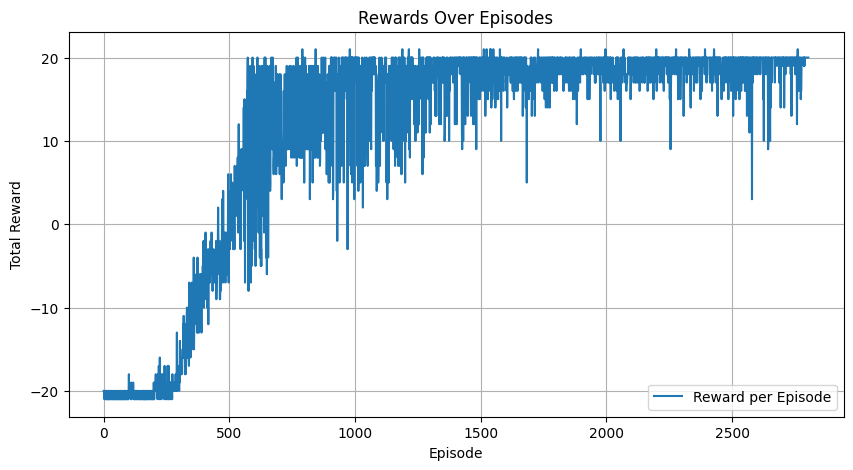

In [10]:
# Plot rewards_per_episode
plt.figure(figsize=(10, 5))
plt.plot(rewards_per_episode, label="Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards Over Episodes")
plt.grid(True)
plt.legend()
plt.savefig("/workspace/ppo_pong_checkpoints/rewards_plot.png")
plt.show()

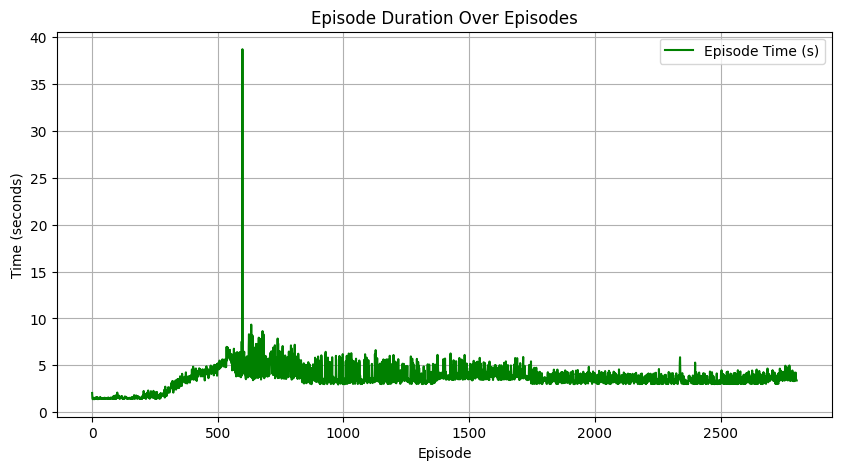

In [12]:
# Plot episode_times
plt.figure(figsize=(10, 5))
plt.plot(episode_times, label="Episode Time (s)", color="green")
plt.xlabel("Episode")
plt.ylabel("Time (seconds)")
plt.title("Episode Duration Over Episodes")
plt.grid(True)
plt.legend()
plt.savefig("/workspace/ppo_pong_checkpoints/episode_times_plot.png")
plt.show()

In [17]:
# Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PPONet().to(device)
model_path = '/workspace/ppo_pong_checkpoints/ppo_pongnoframeskip_env_v5.pth'
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()

rewards_arr = []
for episode in range(10):
    obs, _ = pong_env.reset()
    state = obs
    tot_reward = 0
    done = False
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            actions, _ = model(state_tensor)
            action = actions.argmax(dim=1).item()
        obs, reward, done, _, _ = pong_env.step(action)
        state = np.array(obs, dtype=np.float32)
        tot_reward += reward
    rewards_arr.append(tot_reward)
    print(f"Episode {episode + 1}: Total Reward = {tot_reward}")

# Average reward
avg_reward = np.mean(rewards_arr)
print(f"\nAverage Reward over 10 episodes: {avg_reward}")

Episode 1: Total Reward = 20.0
Episode 2: Total Reward = 20.0
Episode 3: Total Reward = 21.0
Episode 4: Total Reward = 20.0
Episode 5: Total Reward = 21.0
Episode 6: Total Reward = 21.0
Episode 7: Total Reward = 21.0
Episode 8: Total Reward = 20.0
Episode 9: Total Reward = 21.0
Episode 10: Total Reward = 21.0

Average Reward over 10 episodes: 20.6


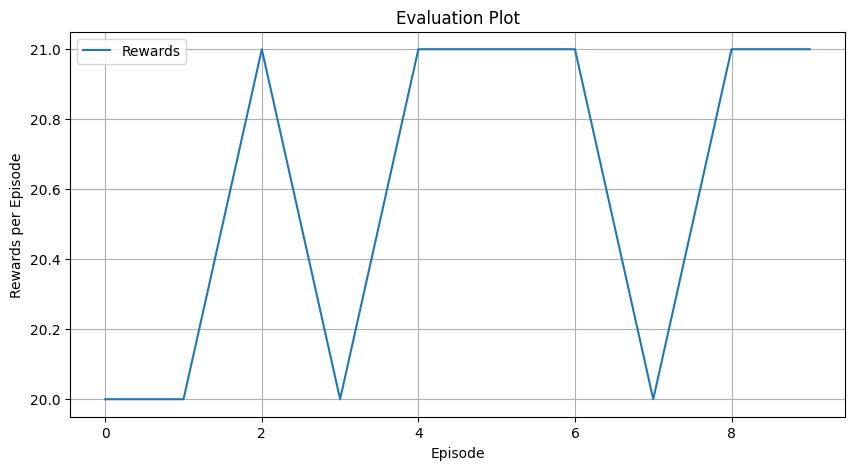

In [18]:
# Plot episode_times
plt.figure(figsize=(10, 5))
plt.plot(rewards_arr, label="Rewards")
plt.xlabel("Episode")
plt.ylabel("Rewards per Episode")
plt.title("Evaluation Plot")
plt.grid(True)
plt.legend()
plt.savefig("/workspace/ppo_pong_checkpoints/evaluation_plot.png")
plt.show()